# Question 1

In [1]:
import numpy as np
import matplotlib as plt 
import matplotlib.image as img

In [2]:
class Conv2D:
    def __init__(self,kernel_size,kernel_num,stride):
        self.kernel_size = kernel_size
        self.kernel_num = kernel_num
        self.kernel = np.random.randn(kernel_size,kernel_size,kernel_num)
        self.w = self.kernel
        self.b = np.ones([1,kernel_num])
        self.stride = stride
        
    def forward(self,input_tensor):
        
        #ADDING APPROPRIATE PADDING
        
        pad = int((self.kernel_size-1)/2)
        self.input = input_tensor
        self.padded_input = np.pad(input_tensor,
                                   pad_width=((pad,pad),(pad,pad),(0,0)))
        img_h,img_w,img_c = np.array(self.input).shape
        conv_output = np.zeros((img_h,img_w,self.kernel_num))

        for c in range(self.kernel_num):
            for h in range(img_h):
                if h%self.stride==0:     #ADDING STRIDE PART
                    for w in range(img_w):
                        if w%self.stride == 0:  #ADDING APPROPRIATE STRIDE
                            #USING APPROPRIATE PADDED INPUT
                            patch = self.padded_input[h:h + self.kernel_size,
                                                      w:w + self.kernel_size,:]
                            kernel = self.kernel[:,:,c].reshape((self.kernel_size,
                                                                self.kernel_size,
                                                                1))
                            conv_output[h,w,c] = np.sum(patch*kernel)+self.b[0][c]
        
        self.output = conv_output
        
    def backward(self,b_input):
        self.b_output = np.zeros(snp.array(elf.input).shape)
        img_h,img_w,img_c = np.array(self.input).shape
        for h in range(img_h):
            if h%self.stride==0:   #ADDING STRIDE PART
                for w in range(img_w):
                    if w%self.stride==0:  #ADDING APPROPRIATE STRIDE
                    
                        patch = self.padded_input[h:h + self.kernel_size,
                                                  w:w + self.kernel_size,:]
                        for c in range(img_c):                        
                            self.b_output[h,w,c] = np.sum(patch*np.sum(b_input[h,w,:]))

In [3]:
kernel_size = int(input("kernel_size = "))
stride = int(input("stride = "))
Layer = Conv2D(kernel_size,8,stride)

kernel_size = 3
stride = 2


# Question2

In [4]:
image = img.imread('kittens.JPEG')
print(np.shape(image))

(1600, 2507, 3)


In [5]:
class Dense:
    def __init__(self,n_inputs,n_neurons):
        self.w = np.random.randn(n_inputs,n_neurons)   #w
        self.b = np.ones([1,n_neurons])    #b
        self.weight_history = 0
        self.bias_history = 0
    
    def forward(self,inputs):
        self.input = inputs  #p
        self.output = np.dot(inputs,self.w)+self.b
    
    def backward(self,b_input):
        self.b_output = np.dot(b_input,self.w.T)
        self.g_w = np.dot(self.input.T,b_input)
        self.g_b = np.sum(b_input,axis=0,keepdims=True)

In [6]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.input = inputs
    
    def backward(self,b_input):
        self.b_output = b_input
        self.b_output[self.input<=0] = 0

In [7]:
class Softmax:

    def forward(self,inputs):
        neuron_output = np.exp(inputs-np.max(inputs,axis=1,keepdims=True))
        self.output = neuron_output/np.sum(neuron_output,axis = 1,keepdims=True)
    
    def backward(self,b_input):
        self.b_output = b_input
        for i , (item1 , item2) in enumerate(zip(self.output,b_input)):
            item1 = item1.reshape(-1,1)
            #sd means softmax derivative
            sd = np.diagflat(item1)-np.dot(item1,item1.T)
            #if j=k: S_j-(S_j)^2
            #if j!=k: 0-(S_j)*(S_k)
            self.b_output[i] = np.dot(sd,item2)

In [8]:
Layer1 = Conv2D(3,4,1)
Act1 = ReLU()

Layer1.forward(image)
Act1.forward(Layer1.output)

print(np.shape(Act1.output))



(1600, 2507, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


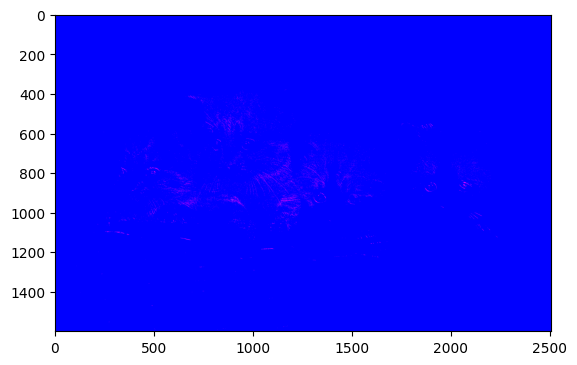

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(Act1.output)

# Question 3

In [10]:
class MaxPoolND:
    def __init__(self, window_size, stride):
        self.window_size = window_size
        self.stride = stride
        
    
    # A Max Pooling layer using a pool size of 2.
    def iterate_regions(self, image):
        '''
        Generates non-overlapping self.window_size * self.window_size  image regions to pool over.
        - image is a 2d numpy array
        '''
        h, w, _ = image.shape
        new_h = h // self.window_size 
        new_w = w // self.window_size 

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * self.window_size ):(i * self.window_size  + self.window_size ), (j * self.window_size ):(j * self.window_size + self.window_size)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h / self.window_size , w / self.window_size , num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // self.window_size, w // self.window_size, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            if i%self.stride == 0 and j%self.stride ==0:
                output[i, j] = np.amax(im_region, axis=(0, 1))

        self.output = output

    def backward(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if i2%self.stride == 0 and j2%self.stride ==0:
                            # If this pixel was the max value, copy the gradient to it.
                            if im_region[i2, j2, f2] == amax[f2]:
                                d_L_d_input[i * self.window_size + i2, j * self.window_size + j2, f2] = d_L_d_out[i, j, f2]

        self.b_output =  d_L_d_input

In [11]:
stride = input("stride = ")
win_size = input("win_size = ")
MaxPoolND(win_size,stride)

stride = 1
win_size = 2


# Question 4

In [12]:
Layer1 = Conv2D(3,8,1)
Act1 = ReLU()

Layer2 = Conv2D(5,16,1)
Act2 = ReLU()

Layer3 = MaxPoolND(2,2)

Layer4 = Conv2D(3,8,1)
Act4 = ReLU()

#chegal layer
Layer5 = Dense(8,64)
Act5 = ReLU()


#chegal layer
Layer6 = Dense(64,1)
Act6 = Softmax()


In [13]:
class Categorical_Cross_Entropy_loss:
    def __init__(self):
        pass
    def forward(self,softmax_output,class_label):
        softmax_output = np.clip(softmax_output,0.000001,0.999999)
        cc = np.sum(softmax_output*class_label,axis=1)
        return np.sum(-np.log(cc)).reshape(-1)
    
    def backward(self,softmax_output,class_label):
        self.b_output = -class_label/softmax_output

In [14]:
Loss = Categorical_Cross_Entropy_loss()


# Question 5

In [15]:
import numpy as np
import pandas as pd
import matplotlib as plt 
import matplotlib.image as img
from matplotlib.image import imread


In [16]:
def get_image():
    imag = []
    label = []
    
    for k in range(5):
        k = k+1
        img = imread(f'usps_{k}.JPG')

        for i in range(34):
            for j in range(33):
                m = img[i * 16:(i + 1) * 16, j * 16:(j + 1) * 16]
                if not (j == 32 and i >= 12):
                    imag.append(m)
                    label.append(k)

    return imag,label

In [17]:
x_train,y_train = get_image()

In [18]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [20]:
for i in range(10):
    Layer1.forward(x_train)
    Act1.forward(Layer1.output)

    Layer2.forward(Act1.output)
    Act2.forward(Layer2.output)

    Layer3.forward(Act2.output) #reshape(-1,1) equals flattening

    Layer4.forward(Layer3.output)
    Act4.forward(Layer4.output)
    
    print(np.shape(Act4.output))
    
    Layer5.forward(Act4.output) #reshape(-1,1) equals flattening
    Act5.forward(Layer5.output)

    Layer6.forward(Act5.output) #reshape(-1,1) equals flattening
    Act6.forward(Layer6.output)

    Loss.forward(Act6.output,y_train)
    
    print('accuracy for epoch'+str(i)+":"+ str(np.mean(y_train == Act6.output)))

    y_train = np.array(y_train)
    Loss.backward(Act6.output,y_train)
    
    Act6.backward(Loss.b_output)
    Layer6.backward(Act6.b_output)
    
    Act5.backward(Loss.b_output)
    Layer5.backward(Act5.b_output)

    Act4.backward(Loss.b_output)
    Layer4.backward(Act4.b_output)

    Layer3.backward(Act4.b_output)

    Act2.backward(Layer3.b_output.reshape(50,40,-1)) #reshape(h,w,-1)
    Layer2.backward(Act2.b_output)

    Act1.backward(Layer2.b_output.reshape(50,40,-1)) #reshape(h,w,-1)
    Layer1.backward(Act1.b_output)


(2750, 8, 8)
accuracy for epoch0:0.025


C:\Users\Ansar9811291\AppData\Local\Temp\ipykernel_10720\3521203319.py:10: RuntimeWarning: divide by zero encountered in true_divide
  self.b_output = -class_label/softmax_output


ValueError: shapes (2750,8,5500) and (1,64) not aligned: 5500 (dim 2) != 1 (dim 0)

In [21]:
for i in range(1):
    Layer1.forward(x_train)
    Act1.forward(Layer1.output)

    Layer2.forward(Act1.output)
    Act2.forward(Layer2.output)

    Layer3.forward(Act2.output) #reshape(-1,1) equals flattening

    Layer4.forward(Layer3.output)
    Act4.forward(Layer4.output)
    
    print(np.shape(Act4.output))
    
    Layer5.forward(Act4.output) #reshape(-1,1) equals flattening
    Act5.forward(Layer5.output)

    Layer6.forward(Act5.output) #reshape(-1,1) equals flattening
    Act6.forward(Layer6.output)

    Loss.forward(Act6.output,y_train)
    
    print('accuracy for epoch'+str(i)+":"+ str(np.mean(y_train == Act6.output)))

    y_train = np.array(y_train)
    Loss.backward(Act6.output,y_train)
    
    Act6.backward(Loss.b_output)
    Layer6.backward(Act6.b_output)
    
    Act5.backward(Loss.b_output)
    Layer5.backward(Act5.b_output)

    Act4.backward(Loss.b_output)
    Layer4.backward(Act4.b_output)

    Layer3.backward(Act4.b_output)

    Act2.backward(Layer3.b_output.reshape(50,40,-1)) #reshape(h,w,-1)
    Layer2.backward(Act2.b_output)

    Act1.backward(Layer2.b_output.reshape(50,40,-1)) #reshape(h,w,-1)
    Layer1.backward(Act1.b_output)


(2750, 8, 8)
accuracy for epoch0:0.025


C:\Users\Ansar9811291\AppData\Local\Temp\ipykernel_10720\3521203319.py:10: RuntimeWarning: divide by zero encountered in true_divide
  self.b_output = -class_label/softmax_output


ValueError: shapes (2750,8,5500) and (1,64) not aligned: 5500 (dim 2) != 1 (dim 0)